In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import pickle 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [2]:
from torch.utils.data import DataLoader, TensorDataset
from copy import deepcopy as copy

In [3]:
look_back = 50

In [70]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size=16, out_size=100, num_layers=1):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.bn1 = nn.BatchNorm1d(num_features=1)
        self.linear1 = nn.Linear(in_features=hidden_size*look_back, out_features=100, bias=True)
        self.Relu = nn.Tanh()
        self.drop = nn.Dropout(0.75)
        self.linear2 = nn.Linear(in_features=128, out_features=100, bias=True)


    def forward(self, x):
        out, (h,c) = self.lstm(x)

        a, b, c = out.shape
        out = self.bn1(out.reshape(a,1,b*c)) 
        out = self.linear1(out)
        return out

        return out


In [5]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size=16, out_size=100, num_layers=1):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.bn1 = nn.BatchNorm1d(num_features=1)
        self.linear1 = nn.Linear(in_features=hidden_size*look_back, out_features=128, bias=True)
        self.Relu = nn.Tanh()
        self.drop = nn.Dropout(0.75)
        self.linear2 = nn.Linear(in_features=128, out_features=100, bias=True)


    def forward(self, x):
        out, (h,c) = self.lstm(x)

        a, b, c = out.shape
        out = self.bn1(out.reshape(a,1,b*c)) 
        out = self.drop(out)
        out = self.linear1(out)
        out = self.Relu(out)
        out = self.drop(out)
        out = self.linear2(out)

        return out


In [7]:
with open("../Data/train_x.pkl", "rb") as file:
    x_train = pickle.load(file)
# print(x_train)
with open("../Data/train_y.pkl", "rb") as file:
    y_train = pickle.load(file)
with open("../Data/test_x.pkl", "rb") as file:
    x_test = pickle.load(file)
with open("../Data/test_y.pkl", "rb") as file:
    y_test = pickle.load(file)

In [8]:
x_train.shape,x_test.shape

((9486, 463), (2042, 463))

In [9]:
y_train.shape,y_test.shape

((9486, 100), (2042, 100))

In [10]:
X = pd.concat([x_train,x_test])
y = pd.concat([y_train,y_test])
X.shape,y.shape

((11528, 463), (11528, 100))

In [11]:
col_1 = ["signed_side","size","price","grossValue","homeNotional","foreignNotional","Midprice_variance","Signed_trade_size_variance","Bid_ask_imbalance","Bid_ask_imbalance_muti","Bid_imbalance","Ask_imbalance","Volume_Order_Imbalance"]

In [12]:
col_2 = [f"Bid{i}" for i in range(10)]+[f"Bidsize{i}" for i in range(10)]+[f"Ask{i}" for i in range(10)]+[f"Asksize{i}" for i in range(10)]

In [13]:
X = X[col_1+col_2]

In [15]:
from sklearn.preprocessing import StandardScaler
scale_X = StandardScaler()
scale_X.fit(X)
scale_Y = StandardScaler()
scale_Y.fit(y)

StandardScaler()

In [16]:
X = scale_X.transform(X)
y = scale_Y.transform(y)

In [12]:
# X_MAX = X.max()
# X_MIN = X.min()
# y_MIn = y.min()
# y_MAX = y.max()

In [13]:
# X = (X-X_MIN)/(X_MAX-X_MIN)

In [14]:
# y = (y-y_MIn)/(y_MAX-y_MIn)

In [17]:
def set_data_seq(data_x,data_y,lookback):
    
    ans = []
    dataX, dataY = [], []
    for i in tqdm(range(lookback,len(data_x))):

        
        dataX.append(data_x[(i-lookback+1):(i+1)])

        dataY.append(data_y[(i):(i+1)])
    return dataX,dataY

In [21]:
X.shape

(11528, 53)

In [22]:
# temp_X = X.copy().reset_index(drop=True)
# temp_y = y.copy().reset_index(drop=True)
# a ,b = set_data_seq(temp_X,temp_y,look_back)

temp_X = X.copy()
temp_y = y.copy()
a ,b = set_data_seq(temp_X,temp_y,look_back)

100%|██████████| 11478/11478 [00:00<00:00, 842133.07it/s]


In [23]:
a,b = np.array(a), np.array(b)

In [24]:
a.shape,b.shape

((11478, 50, 53), (11478, 1, 100))

In [25]:
with open('./a_50_short.pkl', 'wb') as file:
    pickle.dump(a, file)
with open('./b_50_short.pkl', 'wb') as file:
    pickle.dump(b, file)    

In [26]:
with open('a_50_short.pkl', 'rb') as file:
    a = pickle.load(file)
with open('b_50_short.pkl', 'rb') as file:
    b = pickle.load(file)

In [152]:
x_test.shape

torch.Size([1042, 50, 53])

In [110]:
x_train = a[:-1042,:,:].astype(float)
x_test = a[-1042:,:,:].astype(float)
y_train = b[:-1042,:,:].astype(float)
y_test = b[-1042:,:,:].astype(float)

In [ ]:
x_train = torch.tensor(x_train)
x_test = torch.tensor(x_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

In [156]:
x_test.shape

torch.Size([1042, 50, 53])

In [ ]:
batch_size = 64
train_data = TensorDataset(x_train,y_train)
train_dataLoader = DataLoader(train_data, batch_size=batch_size)
test_data = TensorDataset(x_test, y_test)
test_dataLoader = DataLoader(test_data, batch_size=batch_size)

In [117]:
def train_model(epoch, train_data, test_data):
    
    best_model = None
    train_loss = 0
    test_loss = 0
    best_loss = 1000
    epoch_cnt = 0
    for num in range(epoch):
        total_train_loss = 0
        total_train_num = 0
        total_test_loss = 0
        total_test_num = 0
        for x, y in tqdm(train_data, desc="Epoch:{}| Train Loss:{}| Test Loss:{}| Best Loss:{}".format(num, train_loss, test_loss,best_loss)):
            x = x.to(torch.float32)
            y = y.to(torch.float32)
            # y = y.to(torch.float32)
            x = x.to(device=device)
            y = y.to(device=device)
            x_num = len(x)

            p = model_lstm(x)


            loss = loss_func(p, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            total_train_num += x_num
            
        train_loss = total_train_loss / total_train_num
        with torch.no_grad():
            for x, y in test_dataLoader:
                x = x.to(torch.float32)
                y = y.to(torch.float32)
                x = x.to(device=device)
                y = y.to(device=device)
                x_num = len(x)
                p = model_lstm(x)
                loss = loss_func(p, y)
                total_test_loss += loss.item()
                total_test_num += x_num
        test_loss = total_test_loss / total_test_num

        if best_loss > test_loss:
            best_loss = test_loss
            best_model = copy(model_lstm)
            epoch_cnt = 0
            torch.save(best_model.state_dict(),"./LSTM2_07_1.pth")
            
        else:
            epoch_cnt += 1

    torch.save(best_model.state_dict(),"./LSTM2_07_end.pth")
    print("保存成功")


In [217]:

torch.save(model_lstm.state_dict(),"./LSTM2_07_best.pth")

In [251]:

model_lstm.load_state_dict(torch.load("./LSTM2_07_best_256.pth"))

<All keys matched successfully>

In [230]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"    #使用1号

In [231]:

loss_func = nn.L1Loss()
model_lstm = Net(x_train.shape[2])

optimizer = optim.Adam(model_lstm.parameters(), lr=0.0001,weight_decay= 0.000001)
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
torch.cuda.set_device(1)

model_lstm = model_lstm.to(device = device)

In [232]:

optimizer = optim.Adam(model_lstm.parameters(), lr=0.01,weight_decay= 0.000001)
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
model_lstm.train()
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
epoch = 60
train_model(epoch, train_dataLoader, test_dataLoader)

Epoch:0| Train Loss:0| Test Loss:0| Best Loss:1000: 100%|██████████| 164/164 [00:02<00:00, 76.77it/s]
Epoch:1| Train Loss:0.016801152246957447| Test Loss:0.009751874566078187| Best Loss:0.009751874566078187: 100%|██████████| 164/164 [00:02<00:00, 80.27it/s]
Epoch:2| Train Loss:0.011810531661959616| Test Loss:0.009561491876840592| Best Loss:0.009561491876840592: 100%|██████████| 164/164 [00:02<00:00, 78.99it/s]
Epoch:3| Train Loss:0.011774981168094107| Test Loss:0.009628036886453629| Best Loss:0.009561491876840592: 100%|██████████| 164/164 [00:01<00:00, 82.24it/s]
Epoch:4| Train Loss:0.012249026935863147| Test Loss:0.009683454602956772| Best Loss:0.009561491876840592:  49%|████▉     | 80/164 [00:01<00:01, 79.73it/s]


KeyboardInterrupt: 

In [80]:

optimizer = optim.Adam(model_lstm.parameters(), lr=0.00001)
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
model_lstm.train()
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
epoch = 1200
train_model(epoch, train_dataLoader, test_dataLoader)

Epoch:0| Train Loss:0| Test Loss:0| Best Loss:1000: 100%|██████████| 148/148 [00:01<00:00, 76.31it/s]
Epoch:1| Train Loss:1.0393726844916964| Test Loss:1.0895756397247314| Best Loss:1.0895756397247314: 100%|██████████| 148/148 [00:01<00:00, 79.84it/s]
Epoch:2| Train Loss:1.0392913752665405| Test Loss:1.0893221321105957| Best Loss:1.0893221321105957: 100%|██████████| 148/148 [00:01<00:00, 76.95it/s]
Epoch:3| Train Loss:1.0392516576015833| Test Loss:1.0893041324615478| Best Loss:1.0893041324615478: 100%|██████████| 148/148 [00:01<00:00, 77.31it/s]
Epoch:4| Train Loss:1.0392111333157361| Test Loss:1.0893313217163085| Best Loss:1.0893041324615478: 100%|██████████| 148/148 [00:01<00:00, 78.40it/s]
Epoch:5| Train Loss:1.039177835366644| Test Loss:1.0893437023162842| Best Loss:1.0893041324615478: 100%|██████████| 148/148 [00:01<00:00, 79.85it/s]
Epoch:6| Train Loss:1.0391478265630536| Test Loss:1.0893316841125489| Best Loss:1.0893041324615478: 100%|██████████| 148/148 [00:01<00:00, 78.93it/s]

KeyboardInterrupt: 

In [56]:

model_lstm.load_state_dict(torch.load("./LSTM2_07_1.pth"))

<All keys matched successfully>

In [252]:
x_test = a[-2042:-1042,:,:].astype(float)
y_test = b[-2042:-1042,:,:].astype(float)
y_test = torch.tensor(y_test)
x_train = torch.tensor(x_train)
x_test = torch.tensor(x_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)
test_data = TensorDataset(x_test, y_test)
test_dataLoader = DataLoader(test_data, batch_size=batch_size)

/home/image003/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/home/image003/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/image003/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [253]:
import numpy as np

In [254]:
model_lstm.eval()
ans = np.empty([0,100])
for x, _ in test_dataLoader:
    x = x.to(torch.float32)
    x = x.to(device)
    x_num = len(x)
    p = model_lstm(x)
    q = p.squeeze(1).to("cpu").detach().numpy()
    # print(p.shape)
    # break
    ans = np.concatenate((ans, q), axis=0)

In [255]:
ans.shape

(1000, 100)

In [256]:
y_test.shape

torch.Size([1000, 1, 100])

In [257]:
from sklearn.metrics import r2_score

In [258]:
temp = y_test.numpy().copy()
temp = np.squeeze(temp)
temp.shape

(1000, 100)

In [259]:
from sklearn.metrics import r2_score

In [260]:
temp.shape,ans.shape

((1000, 100), (1000, 100))

In [261]:
r2_score(temp[:,0],ans[:,0])

0.00837955399787127

In [262]:
ans_r2_test = [0]*100
for i in tqdm(range(100)):
    y_pre = ans[:,i]
    y_true= temp[:,i]
    ans_r2_test[i] = r2_score(y_true,y_pre)

100%|██████████| 100/100 [00:00<00:00, 5065.16it/s]


In [264]:
len(ans_r2_test)

100

In [265]:
import matplotlib.pyplot as plt
import matplotlib
import os
save_dir = "./Image"
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'  

In [266]:
max(ans_r2_test)

0.25672622863867534

In [248]:
ans_r2_test

[-0.021953349475614115,
 -0.5535735697830311,
 -0.11530034786977605,
 -0.1054055168773651,
 -0.13729715046292257,
 -0.10115747843282041,
 -0.18419759684205772,
 -0.1823408455234501,
 -0.022517203826922794,
 -0.2362339789862371,
 -0.0017187554708590902,
 -0.010418898577700286,
 0.03335016173327543,
 -0.24755886138276395,
 -0.18922605764352873,
 -0.04389832972892993,
 -0.05392649712526709,
 -0.019321859893175475,
 0.02337064690951618,
 0.01306041694524196,
 0.025928752490878337,
 0.024502652012790227,
 0.02260141077853728,
 0.022496591603551108,
 0.03166383285716379,
 0.0013261354303312212,
 0.03181485644142934,
 0.01651011163977456,
 0.023602293497889892,
 0.03538348903351107,
 0.04366963502845278,
 0.01629053917460699,
 0.03526823039980054,
 0.01267605374690739,
 -0.09602349488557071,
 0.017414366407324522,
 0.031011433896282914,
 0.044599956161297305,
 0.037385679059114274,
 0.04297358925198569,
 0.03478582555810095,
 -0.039843928987359334,
 0.044132996673809766,
 0.024140116329649963

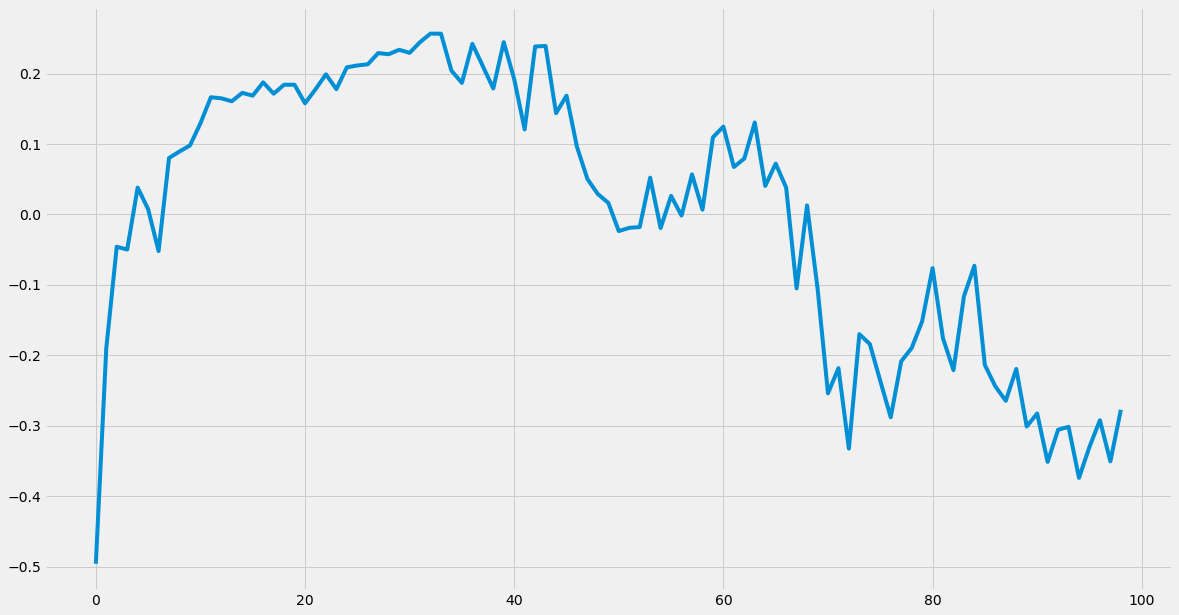

In [225]:
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(18,10))
    plt.plot(ans_r2_test[1:])
    # plt.plot(ans_r2_test)
    fig_file = os.path.join(save_dir, "05-test-r2.png")
    plt.savefig(fig_file, dpi=600, bbox_inches='tight', pad_inches=0.2)
    plt.savefig(fig_file.replace('.png', '.tif'), dpi=600, bbox_inches='tight', pad_inches=0.2,
                pil_kwargs={"compression": "tiff_lzw"})
    plt.savefig(fig_file.replace('.png', '.svg'), format='svg', bbox_inches='tight', pad_inches=0.2)
    plt.show()

In [226]:
len(ans_r2_test)

100

In [228]:
with open('./LSTM2_07_best_256.pkl', 'wb') as file:
    pickle.dump(ans_r2_test, file)